# Variational Monte Carlo with Stochastic Reconfiguration

In [1]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output
from math import exp

from pdb import set_trace

## Make sure that new "Wave Function" Works
This is checking that the code for generating the wave function
and variational projection works where the ratio
between all aphas is fixed

In [2]:
# these are all the possible ground configurations that might
# contribute to the ground states

def get_random_state(num_particles):
    state = []
    positive_positions = random.sample(range(0, num_particles - 1), int(num_particles/2))
    for i in range(num_particles):
        if i in positive_positions:
            state.append(1)
        else:
            state.append(-1)
    return np.asarray(state)

In [174]:
def get_variational_projection(state, alpha):
    """
    The projection of input `state` onto the variational
    wave function. Ie: returns e^omega for the particular
    state
    N === number of particles
    Args:
    - state : N length np array of state represented as +1 or -1
    - alpha : N-1 length of np array of each variational parameter
    Return:
    - coeff (float)
    """
    try:
        return exp(0.5*state[0]*np.dot(state[1:],alpha))
    except OverflowError:
        print(f"Error: Overflow. State = {state}   alpha = {alpha}")
        return None

In [125]:
def get_off_diagonal_configurations(state):
    """
    This function generates a list of configurations that could
    be flipped into the inputted by state by the application of
    Raising or lowering operators (Check the hamiltonian equation)
    
    returns a list of configurations
    
    ***NOTE: This solution is computational intractable and might not
    be the most optimal one
    """
    state_copy = state.copy()
    off_diagonal_configurations = list()
    for i in range(len(state)):
        if i == len(state) - 1:
            if state[i] != state[0]:
                state_copy[i] *= -1
                state_copy[0] *= -1
                off_diagonal_configurations.append(state_copy)
            return off_diagonal_configurations
        if state[i] != state[i+1]:
            state_copy[i] *= -1
            state_copy[i+1] *= -1
            off_diagonal_configurations.append(state_copy)
            state_copy = state.copy()

In [126]:
do_print = False

In [170]:
def calculate_local_energy(state, alpha):
    """
    This function calculates the local energy of a state
    """
    # print(f"State for calc local energy: {state}")
    # contribution from Z direction spin terms
    energy = 0
    state_proj = get_variational_projection(state, alpha)
    for i in range(len(state)):
        if i == len(state) - 1:
            energy += (state_proj*state[i] * state[0])/4
        else:
            energy += (state_proj*state[i] * state[i+1])/4
    diagonal_energies = energy
            
    # contributions from off diagonal terms
    non_diagonal_energies = 0
    off_diag_config_states = get_off_diagonal_configurations(state)
    for configuration in off_diag_config_states:
        non_diagonal_energies += (-0.5)*get_variational_projection(configuration, alpha)
    energy += non_diagonal_energies
    
    if do_print:
        print(f"Non-diag config: {off_diag_config_states}")
        print(f"Diag Energy: {diagonal_energies}")
        print(f"Non Diag energies: {non_diagonal_energies}")
    
    
    return energy / state_proj

In [171]:
calculate_local_energy(np.asarray([1, -1, 1, -1]), -0.75*np.asarray([1, 0.5, 1]))

Non-diag config: [array([-1,  1,  1, -1]), array([ 1,  1, -1, -1]), array([ 1, -1, -1,  1]), array([-1, -1,  1,  1])]
Diag Energy: -1.3247847587288655
Non Diag energies: -2.1965702806156515


-2.6580582363608003

In [143]:
def compute_R(trial_state, initial_state, alpha):
    """
    Function compute "R", which is the ratio between the weight functions
    of the initial state and the trial state.
    """
    numerator = get_variational_projection(trial_state, alpha) **2
    denominator = get_variational_projection(initial_state, alpha) **2
    if denominator < numerator:
        return 2.0
    return numerator / denominator

In [144]:
def random_flip(state):
    """
    Randomly flips two bits of a state such
    that there are still two up and two down
    """
    choices = random.sample(list(range(0,len(state))), len(state))
    flip1_index = choices.pop()
    flip1_value = state[flip1_index]
    state[flip1_index] *= -1
    cont = True
    while(cont):
        flip2_index = choices.pop()
        if state[flip2_index] != flip1_value:
            state[flip2_index] *= -1
            cont = False
    return state

In [145]:
def monte_carlo_estimation(alpha, num_steps, num_particles):
    # only works for even number of particles
    assert num_particles %2 == 0, "Number of particles must be even"

    x_initial = get_random_state(num_particles)
    running_total = 0
    for i in range(num_steps):
        if i % 750 == 0:
            clear_output(wait=True)
            print(f"Alpha: {alpha[0]} -- Step: {i+1}/{num_steps}")
        x_trial = random_flip(x_initial.copy())
        R = compute_R(x_trial, x_initial, alpha)
        r = random.uniform(0,1)
        if R > r:
            x_initial = x_trial.copy()
        running_total += calculate_local_energy(x_initial, alpha)
    return running_total / num_steps

In [146]:
def get_optimal_alpha(alpha_factors, num_particles, num_steps=5000):
    energies = list()
    for i, alpha_factor in enumerate(alpha_factors):
        alpha = alpha_factor*np.asarray([1,0.5,1])
        energies.append(monte_carlo_estimation(alpha, num_steps, num_particles))
    return alpha_factors[np.argmin(energies)], np.argmin(energies), energies

In [147]:
# This function was derived analytically, and represents
# what we should expect out of the energy curve

def ground_truth_variational_energy(alpha):
    """
    with respect to alpha
    """
    numerator = -4*exp(-2*alpha) + -1*exp(-3*alpha)
    denominator = 2*exp(-1*alpha) + exp(-3*alpha)
    
    return numerator/denominator

Alpha: 4.0 -- Step: 4501/5000


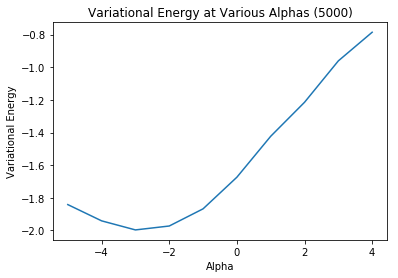

Optimal Alpha Factor found at -3
Minimum Energy: -1.9970677930834289


In [148]:
## alphas = [i*0.05 for i in range(20,40)]
num_steps = 5000
num_particles = 4
alpha_factors = [i*1 for i in range(-5,5)]
xs = np.asarray([i*1 for i in range(-5, 5)])
ys = np.asarray([ground_truth_variational_energy(x) for x in xs])

optimal_alpha_factor, index, energies = get_optimal_alpha(alpha_factors, num_particles, num_steps=num_steps)

plt.plot(alpha_factors, energies)
# plt.xlim(1,2)
plt.ylim()
plt.ylabel("Variational Energy")
plt.xlabel("Alpha")
plt.title(f"Variational Energy at Various Alphas ({num_steps})")
plt.show()
print(f"Optimal Alpha Factor found at {optimal_alpha_factor}")
print(f"Minimum Energy: {energies[index]}")

## Add Stochastic Reconstruction

In [198]:
# functions to calculate variables of interest
# with a given state as input
# expection values will be calcualate by averaging
# these functions over many states

# this are intermediate variables defined in my
# physical notebook

def calculate_delta_x(state, alpha):
    """
    This function gives the delta vector for a particular
    state. The delta vector is a vector with the derivative
    of the wave function with respect to the particular
    indexed paramater. The len the vector is the 
    number of particles - 1 which the number of 
    variational paramters.
    args:
    state - number array length N
    return:
    - delta_x : array length N-1 fo derivatives
    """
    return 0.5*state[0]*np.multiply(state[1:], alpha) # before this was 0.5
 
def calculate_P_of_x(delta_x):
    
    """
    Args:
    delta_x : array outputted by the calculate_delta_x function
    returns:
    - matrix of size delta_x by delta_x where 
    value(i,j) = delta_x[i]*delta_x[j]
    """
    temp1 = np.expand_dims(delta_x, axis=0)
    temp1 = np.repeat(temp1, len(delta_x), axis=0)
    temp2 = temp1.T
    return np.multiply(temp1, temp2)

def calculate_Q_of_x(delta_x, local_energy):
    return local_energy*delta_x

In [199]:
do_print = False

In [200]:
def monte_carlo_estimation(alpha, num_steps, num_particles):
    """
    This function calculates expectation values for the 
    4 variables of interest P, Q, 
    """
    # only works for even number of particles
    assert num_particles %2 == 0, "Number of particles must be even"

    x_initial = get_random_state(num_particles)

    # initialize running variables
    expectation_local_energy = 0
    expection_delta = 0
    expectation_P = 0
    expectation_Q =0
    
    for i in range(num_steps):
        clear_output(wait=True)
        if False:
            if i % 500 == 0:
                print(f"Alpha: {alpha[0]} -- Step: {i+1}/{num_steps}")
        x_trial = random_flip(x_initial.copy())
        R = compute_R(x_trial, x_initial, alpha)
        r = random.uniform(0,1)
        if R > r:
            x_initial = x_trial.copy()
        # these "expectation" variables are running totals of the variables/arrays/matrixes.
        # they represent the sum of all the values for all the trial state inputs (x)
        # and will be normalized by dividing by the number of steps after the simulation
        delta_x = calculate_delta_x(x_initial, alpha)
        local_energy = calculate_local_energy(x_initial, alpha)
        P_of_x = calculate_P_of_x(delta_x)
        Q_of_x = calculate_Q_of_x(delta_x, local_energy)

        if do_print:
            print(f"State input: {x_initial}")
            print(f"Local Energy: {local_energy}")
            print(f"P(x) = {P_of_x}")
            print(f"Q(x) = {Q_of_x}")
            print(f"delta(x) = {delta_x}")
        
        expectation_local_energy += local_energy
        expection_delta += delta_x
        expectation_P += P_of_x
        expectation_Q += Q_of_x
    # normalize expectation values
    expectation_local_energy = expectation_local_energy / num_steps
    expectation_delta = expection_delta / num_steps
    expectation_P = expectation_P / num_steps
    expectation_Q = expectation_Q / num_steps
    return expectation_local_energy, expectation_delta, expectation_P, expectation_Q

In [201]:
def get_random_alpha(num_particles):
    alpha = random.sample(range(1, 100), num_particles -1 )
    alpha = np.asarray(alpha)
    alpha = alpha - 50
    alpha = alpha / 25
    return alpha

In [202]:
def update_variational_parameters(alpha, exp_local_energy, exp_delta, exp_P, exp_Q, lr=0.03):
    """
    This function applies the SR technique.
    """
    
    # cap the change in alpha
    d_alpha_cap = 0.3
    
    # contruction the f vector
    f = exp_Q - exp_delta*exp_local_energy
    
    
    # constructing the S matrix
    temp1 = np.expand_dims(exp_delta, axis=0)
    temp1 = np.repeat(temp1, len(exp_delta), axis=0)
    temp2 = temp1.T
    temp3 = np.multiply(temp1, temp2)
    S = exp_P - temp3
    
    if do_print:
        print(f"f vector = {f}")
        print(f"S Matrix = {S}")
    
    # perform the updates
    d_alpha = alpha - lr*np.matmul(np.linalg.inv(S), f)
    
    # cap the changes in each parameter
    for i, param in enumerate(alpha):
        if param > d_alpha_cap:
            d_alpha[i] = d_alpha_cap
        if param < d_alpha_cap:
            d_alpha[i] = -1*d_alpha_cap
            
    alpha = d_alpha
    return alpha

In [203]:
x1 = np.arange(9.0).reshape((3, 3))
x2 = np.arange(3.0); print(x1, x2)
np.matmul(x1, x2)

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]] [0. 1. 2.]


array([ 5., 14., 23.])

In [204]:
def run_stochastic_reconfiguration(num_steps, num_particles, lr):
    show_plot = True
    
    alpha = get_random_alpha(num_particles)
    
    # get inital condition
    alphas = [] # list of all alphas that we test
    alpha1s = []
    alpha2s = []
    alpha3s = []
    energies = [] # list of all energies corresponding to those alphas
    
    # pre loop conditions
    cont = True
    min_energy = 99999999999
    latest_energy = min_energy
    energy = latest_energy
    time_caught_in_local_min = 0
    loop_count = 0
    
    reset_count = 0 # the number of times the alpha was randomly initialized
    
    while(cont):
        try:
            clear_output(wait=True)
            
            if not show_plot:
                if loop_count % 1 == 0:
                    print(f"""Optimal Energy: %3.2f 
                    \nCurrent Energy: %3.2f 
                    \nloop count: %i
                    \nCurrent Alpha: {alpha}
                    """ % (min_energy, energy, loop_count))
            alphas.append(alpha)
            alpha1s.append(alpha[0])
            alpha2s.append(alpha[1])
            alpha3s.append(alpha[2])

            energy, exp_delta, exp_P, exp_Q = monte_carlo_estimation(alpha, num_steps, num_particles)
            energies.append(energy)
            
            if show_plot:
                plt.plot(alpha1s, energies)
                plt.plot(alpha2s, energies)
                plt.plot(alpha3s, energies)
                plt.show()
            # if this energy is lowest, update optimal measurements,
            # and assume you can do better (set end count, i, to zero)
            if energy < (latest_energy - 0.01):
                time_caught_in_local_min = 0
                if energy < min_energy:
                    min_energy = energy
                    opt_alpha = alpha
            # if not, inncrement the end count. If you don't get better
            # after 400 tries, it's probably time to stop
            else:
                time_caught_in_local_min += 1
                if time_caught_in_local_min == 10:
                    if reset_count == 4:
                        cont = False
                    alpha = get_random_alpha(num_particles)
                    reset_count += 1
                    
            latest_energy = energy


            alpha = update_variational_parameters(alpha, energy, exp_delta, exp_P, exp_Q, lr)

            loop_count += 1
        except KeyboardInterrupt:
            cont = False
        
    print(f"Optimal Alpha: {opt_alpha}" )
    print("Optimal Energy: %3.2f" % min_energy)

    return opt_alpha, min_energy, alphas, energies

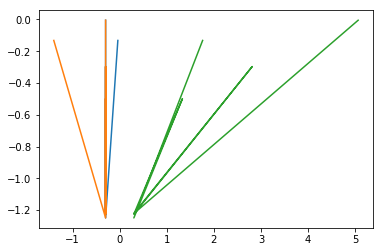

LinAlgError: Singular matrix

In [209]:
run_stochastic_reconfiguration(1000, 4, lr = 0.3)

In [195]:
def run_stochastic_reconfiguration_debug(num_steps, num_particles, lr):
    show_plot = False
    
    alpha =np.asarray([1, -0.5, -2])
    
    # get inital condition
    alphas = [] # list of all alphas that we test
    alpha1s = []
    alpha2s = []
    alpha3s = []
    energies = [] # list of all energies corresponding to those alphas
    
    
    # pre loop conditions
    cont = True
    min_energy = 99999999999
    latest_energy = min_energy
    energy = latest_energy
    time_caught_in_local_min = 0
    loop_count = 0
    
    reset_count = 0 # the number of times the alpha was randomly initialized
    
    while(cont):
        try:
            clear_output(wait=True)
            
            if not show_plot:
                if loop_count % 1 == 0:
                    print(f"""Optimal Energy: %3.2f 
                    \nCurrent Energy: %3.2f 
                    \nloop count: %i
                    \nCurrent Alpha: {alpha}
                    """ % (min_energy, energy, loop_count))
            alphas.append(alpha)
            alpha1s.append(alpha[0])
            alpha2s.append(alpha[1])
            alpha3s.append(alpha[2])

            energy, exp_delta, exp_P, exp_Q = monte_carlo_estimation(alpha, num_steps, num_particles)
            energies.append(energy)
            
            if show_plot:
                plt.plot(alpha1s, energies)
                plt.plot(alpha2s, energies)
                plt.plot(alpha3s, energies)
                plt.show()
            # if this energy is lowest, update optimal measurements,
            # and assume you can do better (set end count, i, to zero)
            if energy < (latest_energy - 0.01):
                time_caught_in_local_min = 0
                if energy < min_energy:
                    min_energy = energy
                    opt_alpha = alpha
            # if not, inncrement the end count. If you don't get better
            # after 400 tries, it's probably time to stop
            else:
                time_caught_in_local_min += 1
                if time_caught_in_local_min == 10:
                    if reset_count == 4:
                        cont = False
                    alpha = get_random_alpha(num_particles)
                    reset_count += 1
                    
            latest_energy = energy


            alpha = update_variational_parameters(alpha, energy, exp_delta, exp_P, exp_Q, lr)
            print(f"New Alpha: {alpha}")
            cont = False

            loop_count += 1
        except KeyboardInterrupt:
            cont = False
        
    print(f"Optimal Alpha: {opt_alpha}" )
    print("Optimal Energy: %3.2f" % min_energy)

    return opt_alpha, min_energy, alphas, energies

In [213]:
run_stochastic_reconfiguration_debug(1000, 4, lr = 0.03)

Non-diag config: [array([ 1, -1,  1, -1]), array([-1,  1, -1,  1])]
Diag Energy: 0.0
Non Diag energies: -1.2840254166877414
State input: [ 1  1 -1 -1]
Local Energy: -0.2231301601484298
P(x) = [[0.25   0.125  0.5   ]
 [0.125  0.0625 0.25  ]
 [0.5    0.25   1.    ]]
Q(x) = [-0.11156508 -0.05578254 -0.22313016]
delta(x) = [0.5  0.25 1.  ]
f vector = [0.296041   0.14210406 0.02366574]
S Matrix = [[ 0.054636    0.025905    0.005652  ]
 [ 0.025905    0.01299375 -0.000165  ]
 [ 0.005652   -0.000165    0.011964  ]]
New Alpha: [ 0.3 -0.3 -0.3]
Optimal Alpha: [ 1.  -0.5 -2. ]
Optimal Energy: -0.54


(array([ 1. , -0.5, -2. ]),
 -0.5373987357476043,
 [array([ 1. , -0.5, -2. ])],
 [-0.5373987357476043])

In [177]:
get_variational_projection([1,-1,1,-1], alpha=[1, -0.5, -2])

1.2840254166877414

In [179]:
calculate_local_energy([1,-1,1,-1], alpha=[1, -0.5, -2])

Non-diag config: [[-1, 1, 1, -1], [1, 1, -1, -1], [1, -1, -1, 1], [-1, -1, 1, 1]]
Diag Energy: -1.2840254166877414
Non Diag energies: -6.041107472865921


-5.704819230486495

In [211]:
do_print = True

In [178]:
1.28/5.75

0.22260869565217392

In [214]:
-0.22*np.asarray([0.5, 0.25, 1])

array([-0.11 , -0.055, -0.22 ])

In [215]:
exp_delta = np.asarray([0.5, 0.25, 1.0 ])

temp1 = np.expand_dims(exp_delta, axis=0)
temp1 = np.repeat(temp1, len(exp_delta), axis=0)
temp2 = temp1.T
temp3 = np.multiply(temp1, temp2)

In [216]:
temp3

array([[0.25  , 0.125 , 0.5   ],
       [0.125 , 0.0625, 0.25  ],
       [0.5   , 0.25  , 1.    ]])